# Measuring Stars and our observations

We'll now measure a few important properties of the data:

 1. Where are the stars?
 2. What is our actual resolution (what was the seeing)?

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.style.use('dark_background')

In [2]:
from astropy.io import fits

We start by loading up some fully-reduced data:

In [3]:
fh = fits.open('NGCSomething_median_combined_V.fits')

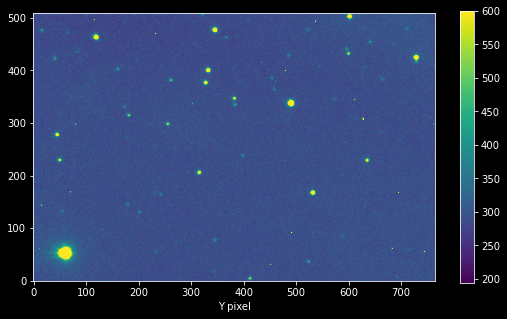

In [4]:
_=pl.figure(figsize=(9,5))
_=pl.imshow(fh[0].data, vmax=600)
_=pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

# Background Subtraction

Notably, the _background level_ is nonzero: we didn't subtract off the sky background!

We need to subtract the background for the following measurements.

In some cases, we need independent measurements of the sky (i.e., separate exposures pointed away from stars) to get a good sky background subtraction.  However, in this case, most of the image is blank sky.  We can estimate the background by taking a simple _median_ of the image.

In [5]:
background = np.median(fh[0].data)
background

292.3294061184989

We can confirm this is a good estimate by looking at the histogram of our data.  Our background estimate is drawn as a vertical dashed line:

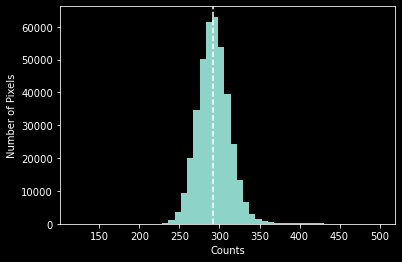

In [6]:
_ = pl.hist(fh[0].data.ravel(), bins=np.linspace(120, 500,))
_ = pl.axvline(background, linestyle='--')
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of Pixels")

We then want to inspect a star.

The star I've picked for the first analysis is at approximately x=530, y=165.  We take a cutout around the star and subtract off the median background level

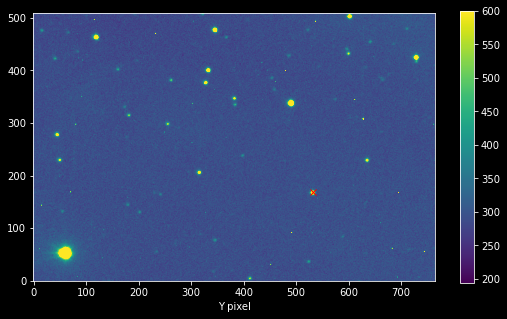

In [7]:
# show where the selected star is
_=pl.figure(figsize=(9,5))
_=pl.imshow(fh[0].data, vmax=600)
_=pl.plot(532,168,'rx')
_=pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

In [8]:
# the cutout is +/-10 pixels around the center
star_cutout = fh[0].data[158:178,522:542] - background

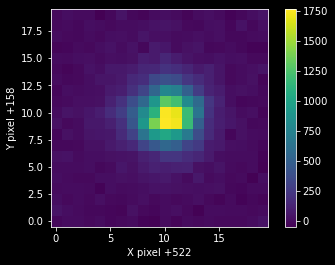

In [9]:
_=pl.imshow(star_cutout)
_=pl.colorbar()
_=pl.xlabel("X pixel +522")
_=pl.ylabel("Y pixel +158")

Note that, now that the background has been subtracted, the background level is near zero.

# Position Measurement - Centroid

We now want to measure the star's position as accurately as we can.  We do this by measuring the *centroid*, the star's intensity-weighted (brightness-weighted) average position.

To estimate the weighted average of the position, we take the _first moment_ of the star in each direction.  

The first-order moment is defined:

$$m_{1} =x_{centroid} = \frac{\Sigma_i x_i F_i}{\Sigma_i F_i}$$


i.e., it is the sum of the coordinate at each pixel ($x_i$) multiplied by the flux at each pixel ($F_i$) divided by the total flux.




Symmetrically, we have the same equation for $y_{cen}$:
$$y_{cen} = \frac{\Sigma_i y_i F_i}{\Sigma_i F_i}$$



### Aside about indexing

Aside/clarification: In the above equation, we use the subscript $_i$ to indicate the "pixel index", but note that there are _two_ pixel indices in the $x$ and $y$ directions.  Since this is a sum, and the order doesn't matter, we can stick with this simple version.  If you wanted to go across x and y, you could rewrite the above as:

$$x_{cen} = \frac{\Sigma_{i,j} x_{i,j} F_{i,j}}{\Sigma_{i,j} F_{i,j}}$$

but we won't bother with that.


### Centroiding Examples
To gain some intuition about what the first moment 
$x_{centroid} = \frac{\Sigma_i x_i F_i}{\Sigma_i F_i}$ means, we can look at a few examples.

#### Example 1: a uniform image.

The centroid will simply be the center of the image.

In [10]:
z = np.ones((4,4))
yc,xc = np.indices(z.shape)
mom1_x = (xc * z).sum() / z.sum()
mom1_y = (yc * z).sum() / z.sum()
mom1_x, mom1_y

(1.5, 1.5)

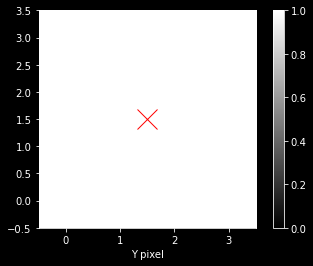

In [11]:
_=pl.imshow(z, cmap='gray', vmin=0, vmax=1)
_=pl.colorbar()
_=pl.plot(mom1_x, mom1_y, 'rx', markersize=20)
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

#### Example 2: A blank image with only one non-zero pixel.

The measured centroid will be the center of that pixel

In [12]:
z = np.zeros((4,4))
z[1,2] = 1
yc,xc = np.indices(z.shape)
mom1_x = (xc * z).sum() / z.sum()
mom1_y = (yc * z).sum() / z.sum()
mom1_x, mom1_y

(2.0, 1.0)

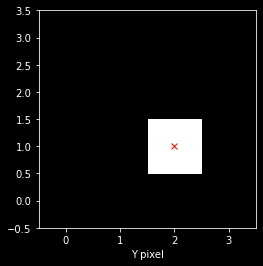

In [13]:
_=pl.imshow(z, cmap='gray')
_=pl.plot(mom1_x, mom1_y, 'rx')
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

### Example 3: two pixels

Two pixels have value 1.  The centroid is  between them

In [14]:
z = np.zeros((4,4))
z[1,2] = 1
z[1,1] = 1
yc,xc = np.indices(z.shape)
mom1_x = (xc * z).sum() / z.sum()
mom1_y = (yc * z).sum() / z.sum()
mom1_x, mom1_y

(1.5, 1.0)

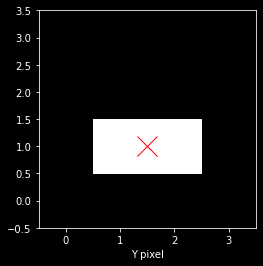

In [15]:
pl.imshow(z, cmap='gray')
pl.plot(mom1_x, mom1_y, 'rx', markersize=20)
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

### Example 4: Nonzero background

What happens if the background is nonzero?  The centroid will naturally shift toward the center!

In [16]:
z = np.ones((4,4)) # ones instead of zeros
z[1,2] += 1
yc,xc = np.indices(z.shape)
mom1_x = (xc * z).sum() / z.sum()
mom1_y = (yc * z).sum() / z.sum()
mom1_x, mom1_y

(1.5294117647058822, 1.4705882352941178)

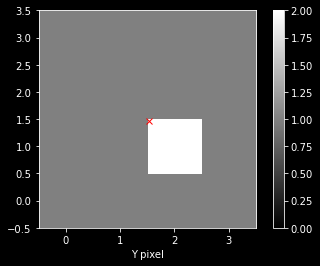

In [17]:
_=pl.imshow(z, cmap='gray', vmin=0, vmax=2)
_=pl.plot(mom1_x, mom1_y, 'rx')
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")
_=pl.colorbar()

This last example shows why background subtraction is critical!  If you don't subtract the background, the centroid will always be pushed toward the center of your cutout - which means you're not really measuring anything!

### Centroiding the star

Then, let's apply the same math to our star cutout:

In [18]:
yc, xc = np.indices(star_cutout.shape)
mom1_x = (xc * star_cutout).sum() / star_cutout.sum()
mom1_y = (yc * star_cutout).sum() / star_cutout.sum()

In [19]:
mom1_x, mom1_y

(9.974412589675339, 9.84484336259887)

We can verify that this is correct by looking at *projections* of the image along each axis.

A "projection" along an axis means we add up all the values along that axis.  It's like looking at the profile of a mountain edge-on from different angles:

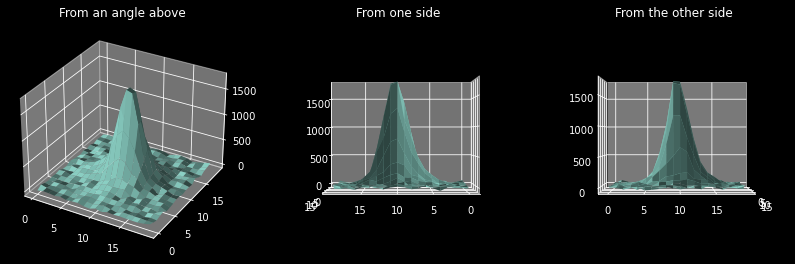

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
Y,X = np.indices(star_cutout.shape)
ax1.plot_surface(X,Y,star_cutout)
ax1.set_title("From an angle above")
ax2.view_init(elev=0, azim=90)
ax2.plot_surface(X,Y,star_cutout)
ax2.set_title("From one side")
ax3.view_init(elev=0, azim=0)
ax3.plot_surface(X,Y,star_cutout)
_=ax3.set_title("From the other side")

In [21]:
proj_x = star_cutout.sum(axis=0) # projection along the y-axis, onto the x-axis
proj_y = star_cutout.sum(axis=1) # projection along the x-axis, onto the y-axis

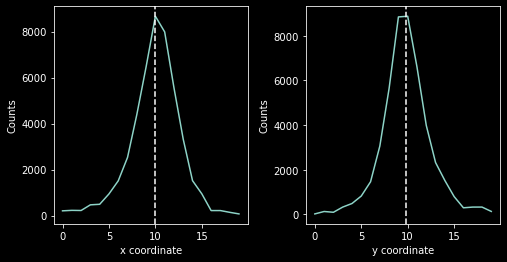

In [22]:
# the curves show the projection of our star
# the dashed lines are where we measured the centroid.  They should be at the middle of the curve

pl.figure(figsize=(8,4))
ax1 = pl.subplot(1,2,1)
ax1.plot(proj_x)
ax1.axvline(mom1_x, linestyle='--')
ax1.set_xlabel("x coordinate")
ax1.set_ylabel("Counts")
ax2 = pl.subplot(1,2,2)
ax2.plot(proj_y)
ax2.axvline(mom1_y, linestyle='--')
_ = ax2.set_xlabel("y coordinate")
_ = ax2.set_ylabel("Counts")
pl.subplots_adjust(wspace=0.3)

In this case, the dashed lines align with the center of the curve.

We can also verify the measurement is good by looking at the star image again, where the `x` marks the centroid position:

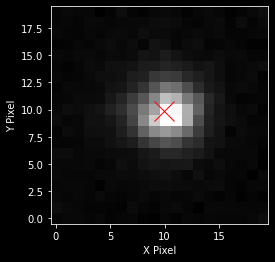

In [23]:
pl.imshow(star_cutout, cmap='gray')
pl.plot(mom1_x, mom1_y, 'rx', markersize=20)
_=pl.xlabel("X Pixel")
_=pl.ylabel("Y Pixel")

# Size measurement

Another important quantity to measure is the *size* of the star.

The size is a measurement of our observation, not of the star!

The *point spread function* (PSF) width is set by *seeing*.  A measurement of the seeing width will tell us how good or bad the seeing was during the observation.

Size can be measured with the second-order moment:

$$m_{2} = E[(x-\mu_x)^2] $$


$$m_{2} =  \sigma_x^2$$


$$m_2 = \frac{\Sigma_i (x_i - x_{cen})^2 F_i}{\Sigma_i F_i}$$

We can show this with a simple Gaussian example:

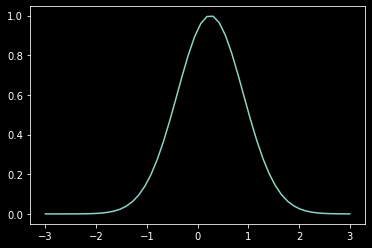

In [24]:
x = np.linspace(-3, 3) # set up our X-axis
x0 = 0.25
sigma = 0.65
y = np.exp(-(x-x0)**2 / (2*sigma**2)) # definition of a Gaussian
_=pl.plot(x,y)

The *second moment* of the data is $m_2 = \frac{\Sigma_i (x_i - x_{cen})^2 F_i}{\Sigma_i F_i}$:

In [25]:
# y = np.exp(-(x-x0)**2 / (2*sigma**2))
m2 = ((x-x0)**2 * y).sum() / y.sum()
m2

0.4224362986118473

So, $\sigma_x = m_2^{1/2}$:

In [26]:
sx = m2**0.5
sx

0.6499509970850474

which is a very good measurement of our input value $\sigma=0.65$ above.

## Width Measurement applied to data


Again, let's apply this measurement to our data:

In [27]:
mom2_x = ((xc - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
mom2_y = ((yc - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
mom2_x, mom2_y # units: pixels^2

(7.126984323992431, 6.514991958186882)

We'll now add a new definition, the *full width at half-maximum*, FWHM, which is a commonly-used measurement of the width that is independent of the curve shape.  

For a Gaussian with width $\sigma$, the FWHM = $\left(\sqrt{8 \ln 2}\right) \sigma \approx 2.35 \sigma$.

In [28]:
# convert "moment 2" to "sigma" first:
sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5

In [29]:
# calculate sigma->fwhm conversion
sigma_to_fwhm = np.sqrt(8*np.log(2))
sigma_to_fwhm

2.3548200450309493

In [30]:
fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
print(sigma_x, sigma_y)
print(fwhm_x, fwhm_y)

2.6696412350711904 2.5524482283068703
6.28652469338682 6.010556251920751


### Verifying the width measurement

We can again verify the quality of this measurement by overlaying on the projections of the image

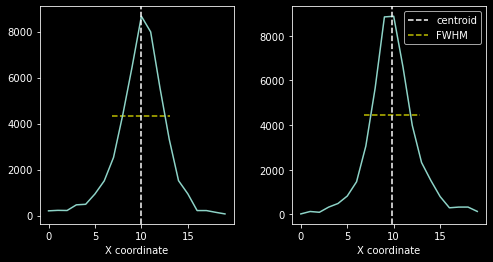

In [31]:
pl.figure(figsize=(8,4))
ax1 = pl.subplot(1,2,1)
proj_x = star_cutout.sum(axis=0)
ax1.plot(proj_x)
ax1.axvline(mom1_x, linestyle='--')
ax1.hlines(0.5*proj_x.max(), mom1_x-fwhm_x/2, mom1_x+fwhm_x/2, color='y', linestyle='--')
ax1.set_xlabel("X coordinate")
ax2 = pl.subplot(1,2,2)
proj_y = star_cutout.sum(axis=1)
ax2.plot(proj_y)
ax2.axvline(mom1_y, label='centroid', linestyle='--')
ax2.hlines(0.5*proj_y.max(), mom1_y-fwhm_y/2, mom1_y+fwhm_y/2, 'y', label='FWHM', linestyle='--')
pl.legend(loc='best')
ax2.set_xlabel("X coordinate")
pl.subplots_adjust(wspace=0.3)

We can also show the fit by overlaying an ellipse.

In [32]:
from matplotlib.patches import Ellipse

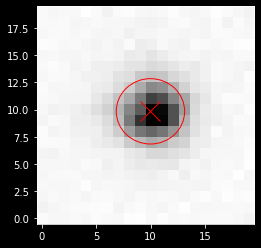

In [33]:
pl.imshow(star_cutout, cmap='gray_r')
pl.plot(mom1_x, mom1_y, 'rx', markersize=20)
_=pl.gca().add_patch(Ellipse((mom1_x, mom1_y), width=fwhm_x, height=fwhm_y, facecolor='none', edgecolor='r'))

We can then, using a known pixel scale we have previously measured, determine what the FWHM is (and therefore what the resolution is) in arcseconds:

In [34]:
from astropy import units as u

In [35]:
pixscale = 0.6*u.arcsec/u.pixel
fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
print(fwhm_x_arcsec, fwhm_y_arcsec)

3.771914816032092 arcsec 3.6063337511524507 arcsec


The geometric average $\left(\Pi x_i\right)^{1/N}$ of these two numbers is our estimate of the circularly-symmetric resolution:

In [36]:
(fwhm_x_arcsec*fwhm_y_arcsec)**0.5

<Quantity 3.68819518 arcsec>

This is a measurement of the seeing at CTO on one night of observations.

# Repeating measurements

We'll repeat the same for the very bright star in the bottom-left.

## STUDENT ANSWER

Before we go on - do you expect it will have the same FWHM (same width), or different?  Why?

probably different, the size will probably change and allow for a larger fit 

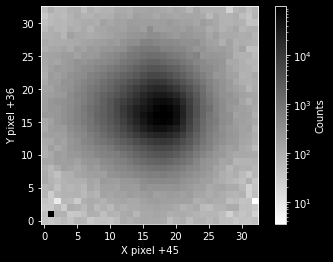

In [37]:
star_cutout2 = fh[0].data[36:69,45:78] - background
pl.imshow(star_cutout2, norm=pl.matplotlib.colors.LogNorm(), cmap='gray_r')
cb=pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +45")
_=pl.ylabel("Y pixel +36")

In [38]:
yc2, xc2 = np.indices(star_cutout2.shape)
mom1_x2 = (xc2 * star_cutout2).sum() / star_cutout2.sum()
mom1_y2 = (yc2 * star_cutout2).sum() / star_cutout2.sum()
mom2_x2 = ((xc2 - mom1_x2)**2 * star_cutout2).sum() / star_cutout2.sum()
mom2_y2 = ((yc2 - mom1_y2)**2 * star_cutout2).sum() / star_cutout2.sum()
fwhm_x2 = mom2_x2**0.5*sigma_to_fwhm
fwhm_y2 = mom2_y2**0.5*sigma_to_fwhm
print(f"moment 1 x,y: {mom1_x2, mom1_y2}, moment 2 x,y: {mom2_x2, mom2_y2}, fwhm x,y: {fwhm_x2, fwhm_y2}")

moment 1 x,y: (17.144752608590768, 16.36875073305479), moment 2 x,y: (11.365062263088966, 9.899319559914078), fwhm x,y: (7.938594769629369, 7.4090136684535075)


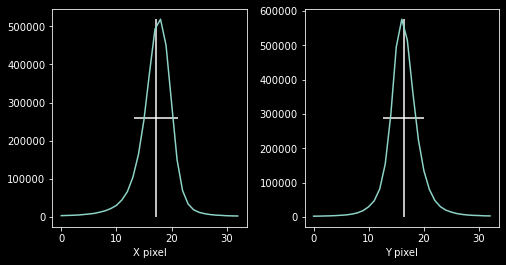

In [39]:
pl.figure(figsize=(8,4))
ax1 = pl.subplot(1,2,1)
proj_x2 = star_cutout2.sum(axis=0)
ax1.plot(proj_x2)
ax1.vlines(mom1_x2, 0, proj_x2.max())
ax1.hlines(0.5*proj_x2.max(), mom1_x2-fwhm_x2/2, mom1_x2+fwhm_x2/2)
ax1.set_xlabel("X pixel")
ax2 = pl.subplot(1,2,2)
proj_y2 = star_cutout2.sum(axis=1)
ax2.plot(proj_y2)
ax2.vlines(mom1_y2, 0, proj_y2.max())
ax2.hlines(0.5*proj_y2.max(), mom1_y2-fwhm_y2/2, mom1_y2+fwhm_y2/2)
ax2.set_xlabel("Y pixel")
pl.subplots_adjust(wspace=0.3)

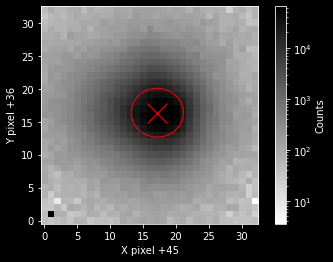

In [40]:
pl.imshow(star_cutout2, norm=pl.matplotlib.colors.LogNorm(vmax=65000), cmap='gray_r')
cb=pl.colorbar()
pl.plot(mom1_x2, mom1_y2, 'rx', markersize=20)
_=pl.gca().add_patch(Ellipse((mom1_x2, mom1_y2), width=fwhm_x2, height=fwhm_y2, facecolor='none', edgecolor='r'))
cb.set_label("Counts")
_=pl.xlabel("X pixel +45")
_=pl.ylabel("Y pixel +36")

Now, let's do one more repeat.  We'll pick the star at about 500,350

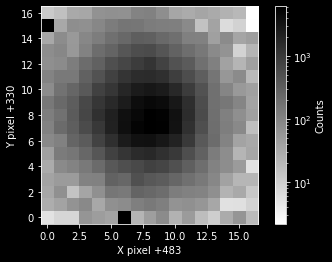

In [41]:
star_cutout3 = fh[0].data[330:347,483:500] - background
pl.imshow(star_cutout3, norm=pl.matplotlib.colors.LogNorm(), cmap='gray_r')
cb=pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +483")
_=pl.ylabel("Y pixel +330")

In [42]:
yc3, xc3 = np.indices(star_cutout3.shape)
mom1_x3 = (xc3 * star_cutout3).sum() / star_cutout3.sum()
mom1_y3 = (yc3 * star_cutout3).sum() / star_cutout3.sum()
mom2_x3 = ((xc3 - mom1_x3)**2 * star_cutout3).sum() / star_cutout3.sum()
mom2_y3 = ((yc3 - mom1_y3)**2 * star_cutout3).sum() / star_cutout3.sum()
fwhm_x3 = mom2_x3**0.5*sigma_to_fwhm
fwhm_y3 = mom2_y3**0.5*sigma_to_fwhm
mom1_x3, mom1_y3, mom2_x3, mom2_y3, fwhm_x3, fwhm_y3
print(f"moment 1 x,y: {mom1_x3, mom1_y3}, moment 2 x,y: {mom2_x3, mom2_y3}, fwhm x,y: {fwhm_x3, fwhm_y3}")

moment 1 x,y: (7.655701942553845, 8.021479350411306), moment 2 x,y: (6.202988585955637, 6.258170168176005), fwhm x,y: (5.864867636631314, 5.8908967110521)


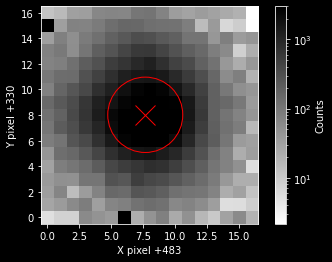

In [43]:
pl.imshow(star_cutout3, norm=pl.matplotlib.colors.LogNorm(vmax=3000,), cmap='gray_r')
cb=pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +483")
_=pl.ylabel("Y pixel +330")
pl.plot(mom1_x3, mom1_y3, 'rx', markersize=20)
_=pl.gca().add_patch(Ellipse((mom1_x3, mom1_y3), width=fwhm_x3, height=fwhm_y3, facecolor='none', edgecolor='r'))

And again for one other...

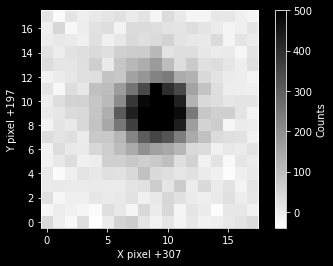

In [44]:
star_cutout4 = fh[0].data[197:215,307:325] - background
pl.imshow(star_cutout4, vmax=500, cmap='gray_r')
cb = pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +307")
_=pl.ylabel("Y pixel +197")

In [45]:
yc4, xc4 = np.indices(star_cutout4.shape)
mom1_x4 = (xc4 * star_cutout4).sum() / star_cutout4.sum()
mom1_y4 = (yc4 * star_cutout4).sum() / star_cutout4.sum()
mom2_x4 = ((xc4 - mom1_x4)**2 * star_cutout4).sum() / star_cutout4.sum()
mom2_y4 = ((yc4 - mom1_y4)**2 * star_cutout4).sum() / star_cutout4.sum()
fwhm_x4 = mom2_x4**0.5*sigma_to_fwhm
fwhm_y4 = mom2_y4**0.5*sigma_to_fwhm
print(f"moment 1 x,y: {mom1_x4, mom1_y4}, moment 2 x,y: {mom2_x4, mom2_y4}, fwhm x,y: {fwhm_x4, fwhm_y4}")

moment 1 x,y: (8.666000744863014, 9.172788675621733), moment 2 x,y: (6.884965090328175, 7.180633819062792), fwhm x,y: (6.178863416917143, 6.310141732998882)


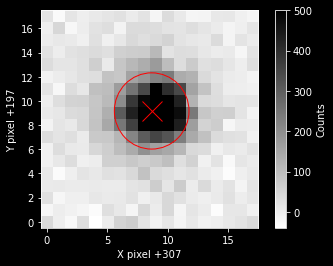

In [46]:
pl.imshow(star_cutout4, vmax=500, cmap='gray_r')
pl.plot(mom1_x4, mom1_y4, 'rx', markersize=20)
pl.gca().add_patch(Ellipse((mom1_x4, mom1_y4), width=fwhm_x4, height=fwhm_y4, facecolor='none', edgecolor='r'))
cb = pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +307")
_=pl.ylabel("Y pixel +197")

To summarize the above measurements, we picked 4 stars and measured the following widths in arcseconds:

In [47]:
fwhm_measurements = [(fwhm_x, fwhm_y),
 (fwhm_x2, fwhm_y2),
 (fwhm_x3, fwhm_y3),
 (fwhm_x4, fwhm_y4),
]*u.pix*pixscale
fwhm_measurements

<Quantity [[3.77191482, 3.60633375],
           [4.76315686, 4.4454082 ],
           [3.51892058, 3.53453803],
           [3.70731805, 3.78608504]] arcsec>

We can take the _geometric average_ of each of these to obtain the circular-average seeing, `(fwhm_x * fwhm_y)**0.5` (note that `fwhm_measurements` is a [4,2] array):

In [48]:
geom_av_fwhm_measurements = (fwhm_measurements[:,0] * fwhm_measurements[:,1])**0.5
geom_av_fwhm_measurements

<Quantity [3.68819518, 4.60154067, 3.52672066, 3.74649455] arcsec>

One of these is a bit of an outlier, as you should have noted above.  Our seeing is approximately:

In [49]:
mean_seeing = np.mean(geom_av_fwhm_measurements[[0,2,3]])
print(f"Median estimate of seeing: {np.median(geom_av_fwhm_measurements):0.2f}")
print(f"Mean estimate of seeing (excluding outlier): {mean_seeing:0.2f}")

Median estimate of seeing: 3.72 arcsec
Mean estimate of seeing (excluding outlier): 3.65 arcsec


Note in the cell above we used an indexing trick to exclude the outlier.  The outlier has index 1, so we can index with all elements except 1:

In [50]:
inds = [0,1,2,3]
# these two are the same: indexing with everything gets you back the original
geom_av_fwhm_measurements[inds], geom_av_fwhm_measurements

(<Quantity [3.68819518, 4.60154067, 3.52672066, 3.74649455] arcsec>,
 <Quantity [3.68819518, 4.60154067, 3.52672066, 3.74649455] arcsec>)

In [51]:
inds = [0,2,3]
# Now the first one will exclude the outlier:
geom_av_fwhm_measurements[inds], geom_av_fwhm_measurements

(<Quantity [3.68819518, 3.52672066, 3.74649455] arcsec>,
 <Quantity [3.68819518, 4.60154067, 3.52672066, 3.74649455] arcsec>)

# Uncertainty

If we make a measurement, we need to know how accurate it is!

The first-order moment is the `centroid`, a measurement of position:

$$m_{1} =x_{centroid} = \frac{\Sigma_i x_i F_i}{\Sigma_i F_i}$$

The second-order moment measures the width (squared):

$$m_{2} = E[(x-\mu_x)^2] = x_{width}^2 = \sigma_x^2 = \frac{\Sigma_i (x_i - x_{cen})^2 F_i}{\Sigma_i F_i}$$


To compute the uncertainty, recall the (approximate) error formula:
$$\sigma_z^2 = \left(\frac{dz}{dx}\right)^2 \sigma_x^2 + \left(\frac{dz}{dy}\right)^2 \sigma_y^2 $$

And its applications for two cases, $z = x y$ and $z = x / y$

$$\sigma_z^2 = \left(\frac{dz}{dx}\right)^2 \sigma_x^2 + \left(\frac{dz}{dy}\right)^2 \sigma_y^2 $$


## Uncertainty rule for multiplication
$$z = x y$$


$$dz/dx = y$$
$$dz/dy = x$$

Substituting, we get:
$$\sigma_z^2 = y^2 \sigma_x^2 + x^2 \sigma_y^2 $$


which can be rearranged by dividing both sides by $z^2$ to get:
$$\sigma_z^2/z^2 = \sigma_x^2/x^2 + \sigma_y^2/y^2 $$


$$\sigma_z^2 = \left(\frac{dz}{dx}\right)^2 \sigma_x^2 + \left(\frac{dz}{dy}\right)^2 \sigma_y^2 $$


$$ z = x / y $$

## Uncertainty rule for division
$$dz/dx = y^{-1}$$

$$\frac{dz}{dy} = - \frac{x}{y^{2}}$$

$$\sigma_z^2 = y^{-2} \sigma_x^2 + \frac{x^2}{y^4} \sigma_y^2 $$

$$\sigma_z^2/z^2 = \sigma_x^2/x^2 + \sigma_y^2/y^2 $$


Using the multiplication rule $\sigma_z^2 = y^2 \sigma_x^2 + x^2 \sigma_y^2 $,
we can break 
$$x_{cen} = \left(\frac{\Sigma_i x_i F_i}{\Sigma_i F_i}\right)$$

down into components. 

 The numerator $\Sigma_i x_i F_i$ is composed of individual $x_i F_i$ products, and has error per element:
$$  \sigma_i^2(x_i F_i) =   \left(\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2 \right)$$



or, because for $z=x+y$, $\sigma_z^2 = \sigma_x^2 + \sigma_y^2$, total error:
$$ \Sigma_i \sigma_i^2(x_i F_i) =  \Sigma_i \left(\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2 \right)$$


Centroid definition, repeated: $$x_{cen} = \left(\frac{\Sigma_i x_i F_i}{\Sigma_i F_i}\right)$$


Put explicitly, the error on the numerator is:

$$ \sigma^2_{numerator} = \Sigma_i \sigma_{x_i}^2(x_i F_i) = \Sigma_i (\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2)$$

Centroid definition, repeated:
$$x_{cen} = \left(\frac{\Sigma_i x_i F_i}{\Sigma_i F_i}\right)$$

The denominator is simpler:
$$ \sigma_{denom}^2 = \sigma^2(\Sigma F_i) =  \Sigma_i \sigma_{F_i}^2$$

By applying
$\sigma_z^2/z^2 = \sigma_x^2/x^2 + \sigma_y^2/y^2 $,
the resulting uncertainty on the centroid $x_{cen} = \left(\frac{\Sigma_i x_i F_i}{\Sigma_i F_i}\right)$
 is:

$$\sigma_{x_{cen}}^2 = x_{cen}^2 \left(\frac{\sigma_{numerator}^2}{(\Sigma_i x_i F_i)^2} + \frac{\sigma_{denom}^2}{(\Sigma_i F_i)^2} \right)$$

Substituting in $x_{cen} = \left(\frac{\Sigma_i x_i F_i}{\Sigma_i F_i}\right)$ and distributing, we can obtain:
$$\sigma_{x_{cen}}^2 =  \left((\Sigma_i F_i)^2 \sigma_{numerator}^2 +  (\Sigma_i x_i F_i)^2 \sigma_{denom}^2\right)$$
but this isn't what we need.

Plugging in our expressions for the numerator and denominator, we obtain:
$$\sigma_{x_{cen}}^2 = x_{cen}^2 \left(\frac{\Sigma_i \left(\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2 \right)}{(\Sigma_i x_i F_i)^2} + \frac{\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^2} \right)$$


Then, substituting in for $x_{cen}$, we have:
$$ = \left(\frac{\Sigma_i x_i F_i}{\Sigma_i F_i}\right)^2 \left(\frac{\Sigma_i \left(\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2 \right)}{(\Sigma_i x_i F_i)^2} + \frac{\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^2} \right)$$


Distributing and canceling terms gives

$$ =  \left(\frac{\Sigma_i \left(\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2 \right)}{ \left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i x_i F_i\right)^2\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^4} \right)$$


$$ \sigma^2_{x_{cen}} =  \left(\frac{\Sigma_i \left(\sigma_{x_i}^2 F_i^2 + \sigma_{F_i}^2 x_i^2 \right)}{\left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i x_i F_i\right)^2\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^4} \right)$$

That might look bad, but let's see what we know now:

The uncertainty on the position, $\sigma_{x_i}$, is actually _zero_.  We know it by definition!  The CCD is on a grid, and we know the grid position locations absolutely.

(caveat: what if there is variation in the sensitivity across a pixel?  This is a real concern for some extremely high-precision use cases, but we won't try to characterize that here as it's a serious research-level task)

So, we can substitute $\sigma_{x_i} = 0$:


$$\sigma_{x_{cen}}^2 = x_{cen}^2 \left(\frac{\Sigma_i \left( \sigma_{F_i}^2 x_i^2 \right)}{(\Sigma_i x_i F_i)^2} + \frac{\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^2} \right) $$

$$ =  \left(\frac{\Sigma_i \left( \sigma_{F_i}^2 x_i^2 \right)}{\left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i x_i F_i\right)^2\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^4} \right)$$

What are the other quantities?

* $F_i$ is the flux (number of counts) in a given pixel: we know it
* $x_i$ is the coordinate of a given pixel: we know it
* $\sigma_{F_i}$ is the _uncertainty_ in a given pixel: we know how to calculate it

So, we can calculate $\sigma_{x_{cen}}$!

$F_i$ and $x_i$ are easy, they are just the image value (`fh[0].data` or `star_cutout`) and the image coordinate (`np.indices(image.shape)`).

$\sigma_F$ is a bit tricky: in principle, it comes from the full pixel noise equation, i.e.:

$$ \sigma_F^2 = \sigma_{RN}^2 + \sigma_{dark}^2 + \sigma_{sky}^2 + \sigma_{signal}^2 $$

and, maybe, we include an additional term of noise added from flat fielding, but ideally that term is negligible (i.e., it is much smaller than the other terms).  

That equation is actually pretty simple: The last three terms are all Poisson noise, $\sigma_{dark}^2 + \sigma_{sky}^2 + \sigma_{signal}^2 = F_{dark} + F_{sky} + F_{signal} = $ what you measured with the CCD

## Bonus Challenge exercise: Error on the flat field
(actually this is probably a bit too tough to do analytically - you can estimate the values of the error added by the flat field if you like)

Demonstrate, using the propagation of error formulae, what the flat field error is.  Argue why it is smaller than the other terms.

Recall that the flat fielded science image will be the science image divided by the dark-subtracted, mean-normalized flat field $F$.

$$F_{darksub} = F_{raw} - D$$
$$\left<F_{darksub}\right> = \Sigma F_{darksub} / N_{pixels}$$
$$F_{norm} = F_{darksub} / \left<F_{darksub}\right>$$

The science fields $S$ have values:
$$S_{darksub} = S_{raw} - D$$
$$S_{flatfielded} = S_{darksub} / F_{norm}$$

Solution:
$$\sigma^2_{F_{darksub}} = \sigma^2_F + \sigma^2_D$$
$$\sigma^2_{\left<F_{darksub}\right>} = \Sigma \sigma^2_{F_{darksub}} / N_{pixels}$$
$$\sigma^2_{F_{norm}} = \sigma_{F_{darksub}}^2 \left<F_{darksub}\right>^{-2} + \left(\Sigma \sigma^2_{F_{darksub}} / N_{pixels}\right) \frac{F_{darksub}^2}{\left<F_{darksub}\right>^4}$$

Recognize that $\sigma_{F_{norm}}^2 \sim 2 \sigma_{F_{darksub}}^2 / \left<F_{darksub}\right>^2$, so the noise on the normalized image is smaller than the raw image by about the mean of the image.

The readnoise is something you estimated from the bias images.  It is about 10 counts, and stays pretty consistent.

So, we have, assuming the flux $F$ is in `electron` units:
$$ \sigma_F^2 = \sigma_{RN}^2 + \sigma_{dark}^2 + \sigma_{sky}^2 + \sigma_{signal}^2 $$
$$   = (10)^2 + F $$
or
$$\sigma_F = \left(100 + F\right)^{1/2}$$


So, we have all the ingredients we need to calculate the error on the centroid.  Let's go through and do that!

Recall that the Poisson noise includes the _sky_ and _dark_ flux.

However, in the example we're working through, I have already subtracted the dark in the original image subtraction.  If you have done your data reduction correctly, you should also have been estimating the uncertainty per pixel as you go!

In [52]:
estimated_dark_current = 4 # this comes from the mean of the bias-subtracted dark image
star_cutout_including_background = fh[0].data[158:178,522:542] + estimated_dark_current
# "background" was the median of the whole image, an estimate of the sky brightness
star_cutout = fh[0].data[158:178,522:542] - background
readnoise_squared = 100 # we estimated the readnoise was about 10 electrons earlier
sigma_squared_F = star_cutout_including_background + readnoise_squared

In [53]:
sigma_squared_F = sigma_squared_F # use uncertainty computed during data reduction.
F = star_cutout
yi, xi = np.indices(star_cutout.shape)

The errors on the centroids $\sigma_{x_{cen}}^2$ and $\sigma_{y_{cen}}^2$ are then:

$$ \sigma_{x_{cen}} =  \left(\frac{\Sigma_i \left( \sigma_{F_i}^2 x_i^2 \right)}{\left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i x_i F_i\right)^2\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^4} \right)^{1/2}$$
$$ \sigma_{y_{cen}} =  \left(\frac{\Sigma_i \left( \sigma_{F_i}^2 y_i^2 \right)}{\left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i y_i F_i\right)^2\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^4} \right)^{1/2}$$

In [54]:
sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)

In [55]:
sigma_squared_xi**0.5, sigma_squared_yi**0.5

(0.14537426915800997, 0.1442811389834938)

So, finally, we have measured errors on the positions of the stars: we have centroided to an accuracy of $\sim0.18$ pixels, or:

In [56]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale

<Quantity [0.08722456, 0.08656868] arcsec>

The error is about 0.11".  Note that that is much better than the seeing!

In [57]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale / mean_seeing

<Quantity [0.02387226, 0.02369276]>

It's 0.03x the seeing-driven resolution, or $\sim30\times$ better.

Relative astrometry (measurement of position) can be done to much higher accuracy than seeing limitations (or diffraction limits) would suggest!

We can look at the limiting behavior of the noise

$$ \sigma_{x_{cen}} =  \left(\frac{\Sigma_i \left( \sigma_{F_i}^2 x_i^2 \right)}{\left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i x_i F_i\right)^2\Sigma_i \sigma_{F_i}^2}{(\Sigma_i F_i)^4} \right)^{1/2}$$

Recalling that $\sigma^2_{F_{i}} \sim F_i$, the centroid error looks something like:
$$ \sigma_{x_{cen}} =  \left(\frac{\Sigma_i \left( F_i x_i^2 \right)}{\left(\Sigma_i F_i\right)^2} + \frac{\left(\Sigma_i x_i F_i\right)^2\Sigma_i F_i}{(\Sigma_i F_i)^4} \right)^{1/2}$$

We can simplify this equation by taking the limit as $F\rightarrow\infty$.

In this case, we note that both terms in the equation reduce to $\frac{1}{F}$

So, in the limit of large $F$, $$\sigma_{x_{cen}} \propto F^{-1/2}$$

In other words, you can centroid brighter things more accurately!

Here is a visual representation of how accurately we were able to measure the centroid.  The errorbars are plotted on top of the image

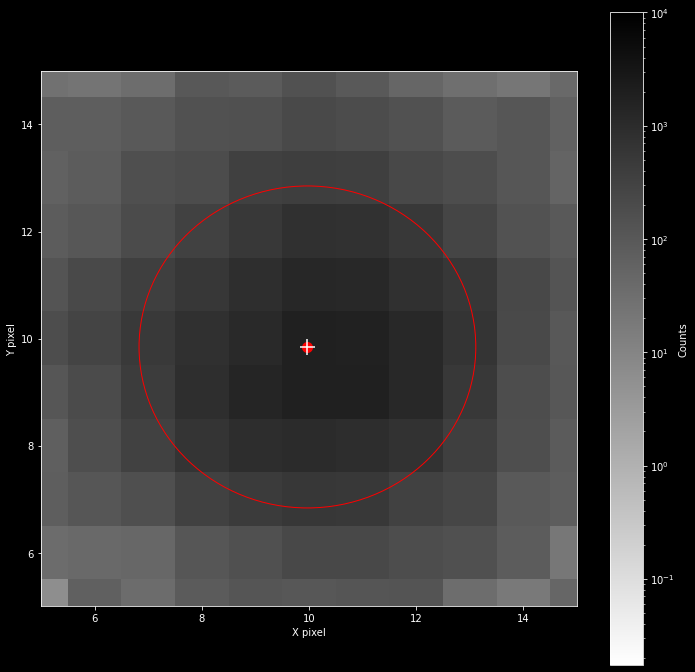

In [58]:
pl.figure(figsize=(12,12))
pl.imshow(star_cutout, norm=pl.matplotlib.colors.LogNorm(vmax=10000,), cmap='gray_r')
cb = pl.colorbar()
cb.set_label("Counts")
pl.plot(mom1_x, mom1_y, 'r.', markersize=20)
pl.errorbar(mom1_x, mom1_y, xerr=sigma_squared_xi**0.5, yerr=sigma_squared_yi**0.5,
            linestyle='none', color='w', zorder=100)
pl.gca().add_patch(Ellipse((mom1_x, mom1_y), width=fwhm_x, height=fwhm_y, facecolor='none', edgecolor='r'))
pl.axis((5,15,5,15))
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

# FIN
lecture ended here

## Student Exercise

Measure the _error on the centroid_ for stars 2, 3, 4.

Measure the centroid, error on the centroid, and the PSF widths for a fifth star.

Report the centroids (the $x$ and $y$ centers) in pixel units in the CCD frame, i.e., report the centers as they are seen in the full CCD image, not as they are seen in the cutouts.

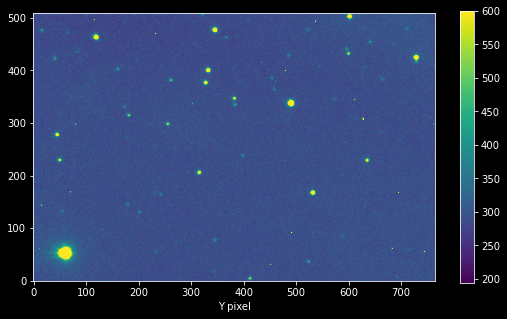

In [59]:
_=pl.figure(figsize=(9,5))
_=pl.imshow(fh[0].data, vmax=600)
_=pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

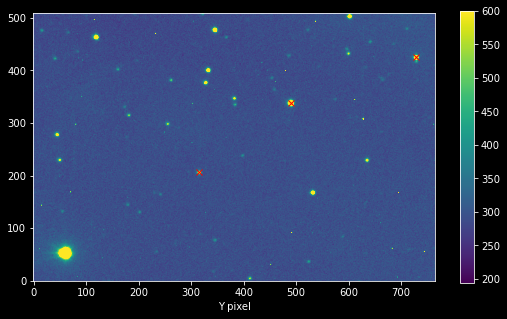

In [60]:
# show where the selected star is
## star at (315, 206) and (490,338)
_=pl.figure(figsize=(9,5))
_=pl.imshow(fh[0].data, vmax=600)
_=pl.plot(315,206,'rx')
_=pl.plot(490,338,'rx')
_=pl.plot(729,426,'rx')
_=pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

# Star cutout 2

## centroiding 

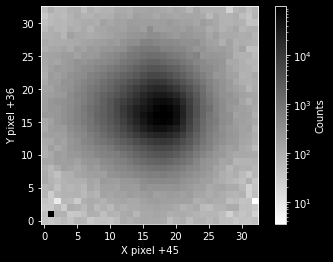

In [61]:
star_cutout2 = fh[0].data[36:69,45:78] - background
pl.imshow(star_cutout2, norm=pl.matplotlib.colors.LogNorm(), cmap='gray_r')
cb=pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +45")
_=pl.ylabel("Y pixel +36")

In [64]:
star_cutout2

array([[ 43.8451093 ,  32.24953391,  41.4850972 , ...,  42.60725431,
         40.69854072,  48.12045015],
       [ 49.50328147, -19.93338053,  73.71344855, ...,  36.63808295,
         49.11642977,  22.87038607],
       [ 31.81352522,  31.90505008,  58.20298826, ...,  44.88956069,
         47.17821628,  35.33879997],
       ...,
       [ 45.74367458,  60.5417844 ,  67.76593525, ...,  79.35848705,
         38.84930946,  42.72110265],
       [ 33.08908026,  55.1482026 ,  65.12807716, ...,  50.81702396,
         36.53939028,  71.83737033],
       [ 48.47778185,  92.81682282,  60.47570211, ...,  80.95098483,
         45.90312421,  68.67070271]])

In [62]:
yc2, xc2 = np.indices(star_cutout2.shape)
mom1_x2 = (xc2 * star_cutout2).sum() / star_cutout2.sum()
mom1_y2 = (yc2 * star_cutout2).sum() / star_cutout2.sum()

In [63]:
mom1_x2, mom1_y2

(17.144752608590768, 16.36875073305479)

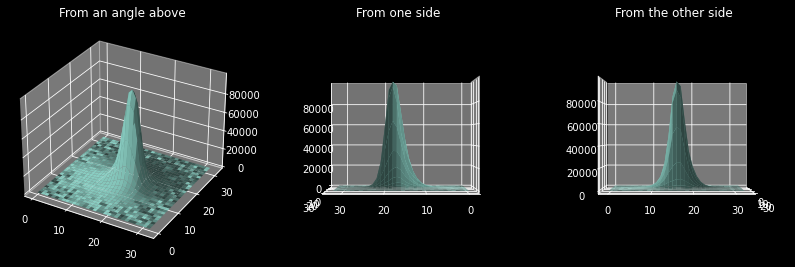

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

Y2,X2 = np.indices(star_cutout2.shape)

ax1.plot_surface(X2,Y2,star_cutout2)
ax1.set_title("From an angle above")

ax2.view_init(elev=0, azim=90)
ax2.plot_surface(X2,Y2,star_cutout2)
ax2.set_title("From one side")

ax3.view_init(elev=0, azim=0)
ax3.plot_surface(X2,Y2,star_cutout2)

_=ax3.set_title("From the other side")

In [103]:
proj_x2 = star_cutout2.sum(axis=0) # projection along the y-axis, onto the x-axis
proj_y2 = star_cutout2.sum(axis=1) # projection along the x-axis, onto the y-axis

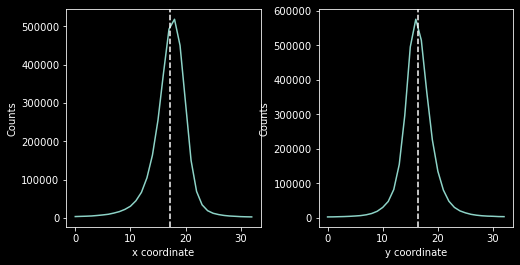

In [104]:
pl.figure(figsize=(8,4))

ax1 = pl.subplot(1,2,1)
ax1.plot(proj_x2)
ax1.axvline(mom1_x2, linestyle='--')
ax1.set_xlabel("x coordinate")
ax1.set_ylabel("Counts")

ax2 = pl.subplot(1,2,2)
ax2.plot(proj_y2)
ax2.axvline(mom1_y2, linestyle='--')

_ = ax2.set_xlabel("y coordinate")
_ = ax2.set_ylabel("Counts")
pl.subplots_adjust(wspace=0.3)

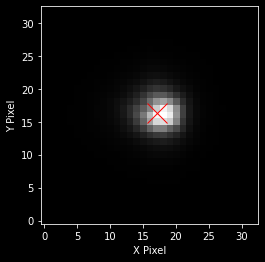

In [105]:
pl.imshow(star_cutout2, cmap='gray')
pl.plot(mom1_x2, mom1_y2, 'rx', markersize=20)
_=pl.xlabel("X Pixel")
_=pl.ylabel("Y Pixel")

# Width measurement 


In [66]:
mom2_x2 = ((xc2 - mom1_x2)**2 * star_cutout2).sum() / star_cutout2.sum()
mom2_y2 = ((yc2 - mom1_y2)**2 * star_cutout2).sum() / star_cutout2.sum()
mom2_x2, mom2_y2 # units: pixels^2

(11.365062263088966, 9.899319559914078)

In [67]:
# convert "moment 2" to "sigma" first:
sigma_x2, sigma_y2 = mom2_x2**0.5, mom2_y2**0.5

In [68]:
# calculate sigma->fwhm conversion
sigma_to_fwhm = np.sqrt(8*np.log(2))
sigma_to_fwhm

2.3548200450309493

# uncertainty 

In [116]:
estimated_dark_current = 4 # this comes from the mean of the bias-subtracted dark image
star_cutout_including_background2 = fh[0].data[36:69,45:78] + estimated_dark_current
# "background" was the median of the whole image, an estimate of the sky brightness
star_cutout = fh[0].data[36:69,45:78] - background
readnoise_squared = 100 # we estimated the readnoise was about 10 electrons earlier
sigma_squared_F = star_cutout_including_background + readnoise_squared

In [122]:
sigma_squared_F = sigma_squared_F # use uncertainty computed during data reduction.
F = star_cutout2
yi, xi = np.indices(star_cutout2.shape)

In [123]:
sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)

In [124]:
sigma_squared_xi**0.5, sigma_squared_yi**0.5

(0.014612733315393393, 0.013992185829089754)

In [125]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale

<Quantity [0.00876764, 0.00839531] arcsec>

In [126]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale / mean_seeing

<Quantity [0.00239959, 0.00229769]>

# Star cutout 3

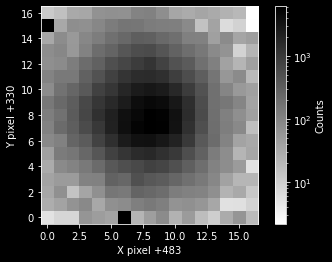

In [98]:
star_cutout3 = fh[0].data[330:347,483:500] - background
pl.imshow(star_cutout3, norm=pl.matplotlib.colors.LogNorm(), cmap='gray_r')
cb=pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +483")
_=pl.ylabel("Y pixel +330")

In [134]:
estimated_dark_current = 4 # this comes from the mean of the bias-subtracted dark image
star_cutout_including_background3 = fh[0].data[330:347,483:500] + estimated_dark_current
# "background" was the median of the whole image, an estimate of the sky brightness
star_cutout3 = fh[0].data[330:347,483:500] - background
readnoise_squared = 100 # we estimated the readnoise was about 10 electrons earlier

sigma_squared_F = star_cutout_including_background3 + readnoise_squared
sigma_squared_F = sigma_squared_F # use uncertainty computed during data reduction.
F = star_cutout3
yi, xi = np.indices(star_cutout3.shape)

sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)

In [135]:
sigma_squared_xi**0.5, sigma_squared_yi**0.5

(0.03634558408522242, 0.03758125613116316)

In [136]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale

<Quantity [0.02180735, 0.02254875] arcsec>

In [137]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale / mean_seeing

<Quantity [0.0059684 , 0.00617131]>

## Star 4

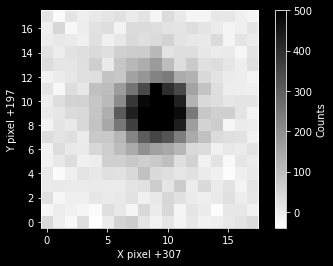

In [128]:
star_cutout4 = fh[0].data[197:215,307:325] - background
pl.imshow(star_cutout4, vmax=500, cmap='gray_r')
cb = pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +307")
_=pl.ylabel("Y pixel +197")

In [138]:
estimated_dark_current = 4 # this comes from the mean of the bias-subtracted dark image
star_cutout_including_background4 = fh[0].data[197:215,307:325] + estimated_dark_current
# "background" was the median of the whole image, an estimate of the sky brightness
star_cutout4 = fh[0].data[197:215,307:325] - background
readnoise_squared = 100 # we estimated the readnoise was about 10 electrons earlier

sigma_squared_F = star_cutout_including_background4 + readnoise_squared
sigma_squared_F = sigma_squared_F # use uncertainty computed during data reduction.
F = star_cutout4
yi, xi = np.indices(star_cutout4.shape)

sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)

In [139]:
sigma_squared_xi**0.5, sigma_squared_yi**0.5

(0.23687825280694136, 0.24392563511657442)

In [140]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale

<Quantity [0.14212695, 0.14635538] arcsec>

In [141]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale / mean_seeing

<Quantity [0.03889836, 0.04005562]>

# Star 5

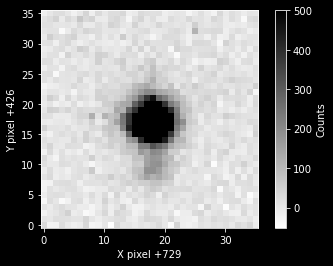

In [145]:
star_cutout5 = fh[0].data[408:444,711:747] - background #729,426 18x12
pl.imshow(star_cutout5, vmax=500, cmap='gray_r')
cb = pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel +729")
_=pl.ylabel("Y pixel +426")

In [146]:
estimated_dark_current = 4 # this comes from the mean of the bias-subtracted dark image
star_cutout_including_background5 = fh[0].data[408:444,711:747] + estimated_dark_current
# "background" was the median of the whole image, an estimate of the sky brightness
star_cutout5 = fh[0].data[408:444,711:747] - background
readnoise_squared = 100 # we estimated the readnoise was about 10 electrons earlier

sigma_squared_F = star_cutout_including_background5 + readnoise_squared
sigma_squared_F = sigma_squared_F # use uncertainty computed during data reduction.
F = star_cutout5
yi, xi = np.indices(star_cutout5.shape)

sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)

In [147]:
sigma_squared_xi**0.5, sigma_squared_yi**0.5

(0.2595456759883925, 0.2549954445613526)

In [148]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale

<Quantity [0.15572741, 0.15299727] arcsec>

In [149]:
(sigma_squared_xi**0.5, sigma_squared_yi**0.5)*u.pix * pixscale / mean_seeing

<Quantity [0.04262063, 0.04187343]>

## centroid

In [150]:
yc5, xc5 = np.indices(star_cutout5.shape)
mom1_x5 = (xc5 * star_cutout5).sum() / star_cutout5.sum()
mom1_y5 = (yc5 * star_cutout5).sum() / star_cutout5.sum()

In [151]:
mom1_x5, mom1_y5

(17.82029826087991, 17.180107940447627)

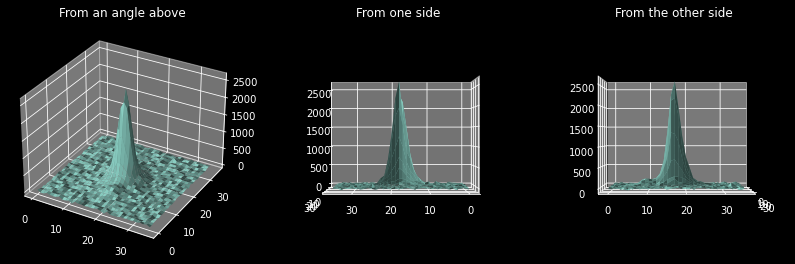

In [153]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

Y5,X5 = np.indices(star_cutout5.shape)

ax1.plot_surface(X5,Y5,star_cutout5)
ax1.set_title("From an angle above")

ax2.view_init(elev=0, azim=90)
ax2.plot_surface(X5,Y5,star_cutout5)
ax2.set_title("From one side")

ax3.view_init(elev=0, azim=0)
ax3.plot_surface(X5,Y5,star_cutout5)

_=ax3.set_title("From the other side")

In [154]:
proj_x5 = star_cutout5.sum(axis=0) # projection along the y-axis, onto the x-axis
proj_y5 = star_cutout5.sum(axis=1) # projection along the x-axis, onto the y-axis

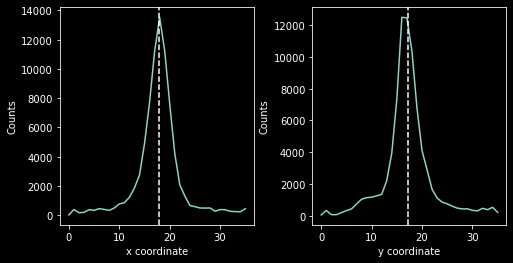

In [155]:
pl.figure(figsize=(8,4))

ax1 = pl.subplot(1,2,1)
ax1.plot(proj_x5)
ax1.axvline(mom1_x5, linestyle='--')
ax1.set_xlabel("x coordinate")
ax1.set_ylabel("Counts")

ax2 = pl.subplot(1,2,2)
ax2.plot(proj_y5)
ax2.axvline(mom1_y5, linestyle='--')

_ = ax2.set_xlabel("y coordinate")
_ = ax2.set_ylabel("Counts")
pl.subplots_adjust(wspace=0.3)

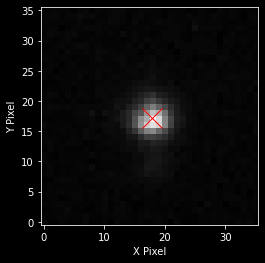

In [156]:
pl.imshow(star_cutout5, cmap='gray')
pl.plot(mom1_x5, mom1_y5, 'rx', markersize=20)
_=pl.xlabel("X Pixel")
_=pl.ylabel("Y Pixel")

In [159]:
yc5, xc5 = np.indices(star_cutout5.shape)

mom2_x5 = ((xc5-mom1_x5)**2 * star_cutout5).sum()/star_cutout5.sum()
mom2_y5 = ((yc5-mom1_y5)**2 * star_cutout5).sum()/star_cutout5.sum()
mom2_x5 = ((xc5-mom1_x5)**2 * star_cutout5).sum()/star_cutout5.sum()

fwhm_x5 = mom2_x5**0.5 * sigma_to_fwhm
fwhm_y5 = mom2_y5**0.5 *sigma_to_fwhm

mom2_x5, mom2_y5, fwhm_x5, fwhm_y5

(20.72774426516159, 23.257922203358806, 10.720961709385714, 11.356465365928152)

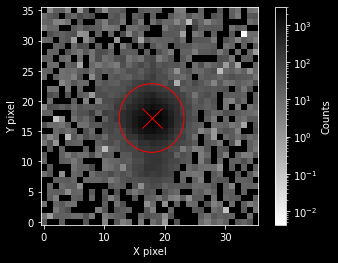

In [161]:
pl.imshow(star_cutout5, norm=pl.matplotlib.colors.LogNorm(vmax=3000), cmap='gray_r')
cb=pl.colorbar()
cb.set_label("Counts")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.plot(mom1_x5, mom1_y5, 'rx', markersize=20)
_=pl.gca().add_patch(Ellipse((mom1_x5, mom1_y5),width=fwhm_x5, height = fwhm_y5, facecolor='none', edgecolor='r'))

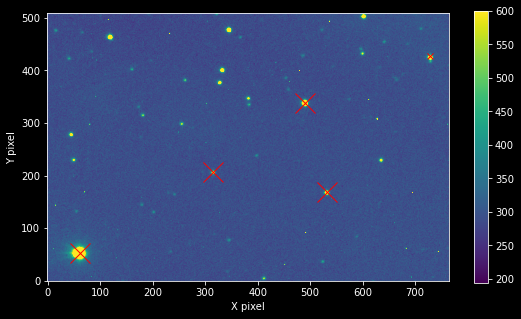

In [171]:
_=pl.figure(figsize=(9,5))
_=pl.imshow(fh[0].data, vmax=600)
pl.plot(mom1_x +522, mom1_y+158, 'rx', markersize=20)
pl.plot(mom1_x2 +45, mom1_y2+36, 'rx', markersize=20)
pl.plot(mom1_x3 +483, mom1_y3+330, 'rx', markersize=20)
pl.plot(mom1_x4 +307, mom1_y4+197, 'rx', markersize=20)
_=pl.plot(mom1_x5 + 710,mom1_y5 + 410,'rx')
_=pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

In [172]:
print(f"Star 1 center x,y (pix): {mom1_x+522,mom1_y+158}")
print(f"Star 2 center x,y (pix): {mom1_x2+45,mom1_y2+158}")
print(f"Star 3 center x,y (pix): {mom1_x3+483,mom1_y3+330}")
print(f"Star 4 center x,y (pix): {mom1_x4+307,mom1_y4+197}")
print(f"Star 5 center x,y (pix): {mom1_x5 + 710,mom1_y5 + 410}")

Star 1 center x,y (pix): (531.9744125896754, 167.84484336259888)
Star 2 center x,y (pix): (62.144752608590764, 174.36875073305478)
Star 3 center x,y (pix): (490.65570194255383, 338.0214793504113)
Star 4 center x,y (pix): (315.666000744863, 206.17278867562175)
Star 5 center x,y (pix): (727.8202982608799, 427.1801079404476)


In [173]:
pwd


"C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\In CLass\\Centroids"